# High order symplectic integrators
This notebook reproduces the plots of Rein, Tamayo & Brown (2019). 

In [32]:
import rebound
from rebound import data
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt

Everything is scaled with respect to Jupiter's orbital period.

In [33]:
sim = rebound.Simulation() # This simulation is only used to get Jupiter's period
data.add_outer_solar_system(sim)
jupiter_period = sim.particles[1].P

These are the 200 logarithmically spaced timesteps which we will test, ranging from $10^{-3}$ to 1 Jupiter period.

In [34]:
dts = jupiter_period*np.logspace(-3,0,200)

These are the settings which we will test.

In [35]:
saba_settings = [
     "SABA1", "SABA2", "SABA3", "SABA4",
     "SABACM2", "SABACM3", "SABACM4",
     "SABACL2", "SABACL3", "SABACL4",
     "SABA(10,4)", "SABA(8,6,4)", "SABA(10,6,4)"]

wh_settings = [
    {'kernel':'default', 'corrector':0, 'corrector2':0},    
    {'kernel':'default', 'corrector':17, 'corrector2':0},
    {'kernel':'composition', 'corrector':17, 'corrector2':0},
    {'kernel':'modifiedkick', 'corrector':17, 'corrector2':0},
    {'kernel':'lazy', 'corrector':17, 'corrector2':0},
    
    {'kernel':'default', 'corrector':0, 'corrector2':1},
    {'kernel':'default', 'corrector':17, 'corrector2':1},
    {'kernel':'composition', 'corrector':17, 'corrector2':1},
    {'kernel':'modifiedkick', 'corrector':17, 'corrector2':1},
    {'kernel':'lazy', 'corrector':17, 'corrector2':1},
]

The following routine runs a simulation twice. First to measure the energy error at 10000 randomly spaced points along the way. And then again to measure the runtime. 

In [36]:
def run(sim):
    sim_time = sim.copy() 
    
    # First measure the energy error
    E0 = sim.calculate_energy()
    E = 0.
    tmax = 1e2*2*np.pi # 10kyr
    samples = tmax*np.sort(np.random.random(10000)) # 10000 random sample points
    for t in samples:
        sim.integrate(t,exact_finish_time=False)
        E1 = sim.calculate_energy()
        E = max(E,np.abs((E1-E0)/E0))

    # Then measure the runtime
    start = time.process_time()
    sim_time.integrate(tmax,exact_finish_time=False)
    stop = time.process_time()

    # Return both runtime and energy error
    return stop-start, E

The following routines set up simulations for use with SABA and WH integrators and the integrate them.

In [6]:
def runsaba(dt,sabatype="SABA4"):
    sim = rebound.Simulation()
    data.add_outer_solar_system(sim)
    sim.move_to_com()    
    sim.dt = dt
    sim.integrator = sabatype
    sim.ri_saba.safe_mode = False
    sim.ri_saba.keep_unsynchronized = True
    return run(sim) #returns runtime and energy error

def runwh(dt,kernel="default",corrector=0,corrector2=0):
    sim = rebound.Simulation()
    data.add_outer_solar_system(sim)
    sim.move_to_com()
    sim.dt = dt
    sim.integrator = "whfast"
    sim.ri_whfast.corrector = corrector
    sim.ri_whfast.corrector2 = corrector2
    sim.ri_whfast.kernel = kernel
    sim.ri_whfast.safe_mode = False
    sim.ri_whfast.keep_unsynchronized = True
    return run(sim) 

Next, we run all the tests. This may take a while (1 one hour). Do not run any other programs which might interfere with the runtime measurements. To speed up the test, reduce `tmax`, the number of timesteps, or the number of settings.

In [ ]:
TEs = np.zeros((len(dts),len(saba_settings),2))
for j,ss  in enumerate(saba_settings):
    for i,dt in enumerate(dts):
        TEs[i,j] = runsaba(dt, ss)
TEwh = np.zeros((len(dts),len(wh_settings),2))
for j,whs  in enumerate(wh_settings):
    for i,dt in enumerate(dts):
        TEwh[i,j] = runwh(dt,**whs) 
np.save("TEs.npy",TEs) # you can also save the results. 
np.save("TEwh.npy",TEwh)        

Alternatively, run the simulations remotely, then just read in the data files:

In [37]:
TEs = np.load("TEs.npy")
TEwh = np.load("TEwh.npy")        

# Energy error versus timestep
Rendering Fig. 1

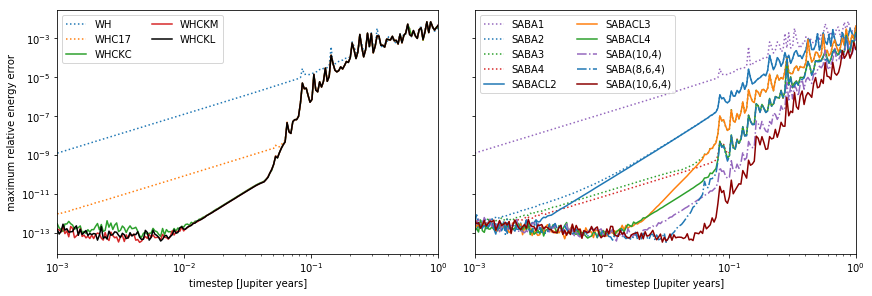

In [38]:
fig,axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True,sharey=True)

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("timestep [Jupiter years]")
    ax.set_xlim([dts[0]/jupiter_period,1])    

ax = axs[0]
ax.set_ylabel("maximum relative energy error")
for j, whs  in enumerate(wh_settings):
    label = "WH"
    ls = "-" 
    if whs['corrector']>0:
        if whs['kernel']=="default":
            label+="C%d"%whs['corrector']
        else:
            label+="C"
    if whs['corrector2']>0:  
        continue # Do not plot (very similar to corrector=0)
        label+="C"
    if whs['kernel']=="modifiedkick":
        label+="KM"    
    elif whs['kernel']=="lazy":
        label+="KL"        
    elif whs['kernel']=="composition":
        label+="KC"      
    elif whs['kernel']=="default":
        ls=":" 

    if whs['kernel']=="lazy" and whs['corrector2']==0:
        color = "black"
    else:
        color=None
    
    ax.plot(dts/jupiter_period,TEwh[:,j,1],label=label,ls=ls,color=color)
ax.legend(ncol=2);
    
ax = axs[1]
for j, ss  in enumerate(saba_settings):
    label = ss 
    if "CM" in ss:
        continue
        ls = "-."
    elif "CL" in ss:
        ls = "-"
    elif "(" in ss:
        ls = "-."    
    else:
        ls = ":"
    if "SABA1" in ss or "10,4" in ss:
        color = "C4"
    elif "SABA2" in ss or "8,6,4" in ss:
        color = "C0"
    elif "SABA3" in ss or "10,6,4" in ss:
        color = "C2"
    elif "SABA4" in ss:
        color = "C3"
    else:
        color = None
    if "SABA(10,6,4)" in ss:
        ls = "-"
        color = "darkred"
        
    ax.plot(dts/jupiter_period,TEs[:,j,1],label=label,ls=ls,color=color)
    
ax.legend(ncol=2);
fig.savefig("outersolarsystem_energy.pdf")

# Energy error versus runtime
Rendering Fig. 2

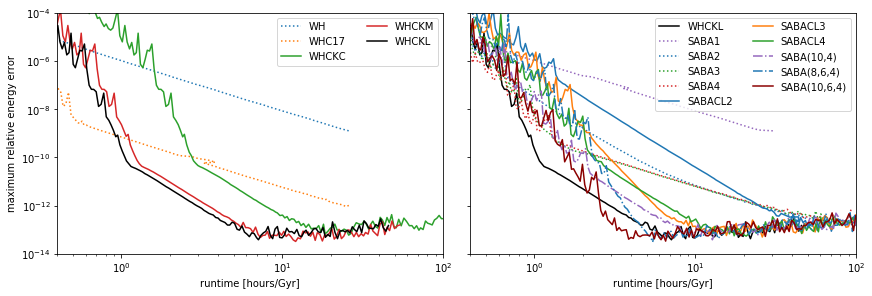

In [39]:
fig,axs = plt.subplots(1,2,figsize=(12,4), constrained_layout=True,sharey=True)

Gyr = 100.*1000./3600. # runtime for 1Gyr in hours

for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("runtime [hours/Gyr]")
    ax.set_xlim([4e-1,1e2])
    ax.set_ylim([1e-14,1e-4])



# Left panel
ax = axs[0]
ax.set_ylabel("maximum relative energy error")
for j, whs  in enumerate(wh_settings):
    label = "WH"
    ls = "-" 
    if whs['corrector']>0:
        if whs['kernel']=="default":
            label+="C%d"%whs['corrector']
        else:
            label+="C"
    if whs['corrector2']>0:
        continue # Do not plot (very similar to corrector=0)
        label+="C"
    if whs['kernel']=="modifiedkick":
        label+="KM"    
    elif whs['kernel']=="lazy":
        label+="KL"        
    elif whs['kernel']=="composition":
        label+="KC"      
    elif whs['kernel']=="default":
        ls=":" 

    if whs['kernel']=="lazy":
        color = "black"
    else:
        color=None
    ax.plot(Gyr*TEwh[:,j,0],TEwh[:,j,1],label=label,ls=ls,color=color)

ax.legend(ncol=2);


# Right panel
ax = axs[1]

for j, whs  in enumerate(wh_settings):
    if whs['kernel']=="lazy" and whs['corrector2']==0:
        ax.plot(Gyr*TEwh[:,j,0],TEwh[:,j,1],label="WHCKL",color="black")    

for j, ss  in enumerate(saba_settings):
    label = ss 
    if "CM" in ss:
        continue
        ls = "-."
    elif "CL" in ss:
        ls = "-"
    elif "(" in ss:
        ls = "-."    
    else:
        ls = ":"
    if "SABA1" in ss or "10,4" in ss:
        color = "C4"
    elif "SABA2" in ss or "8,6,4" in ss:
        color = "C0"
    elif "SABA3" in ss or "10,6,4" in ss:
        color = "C2"
    elif "SABA4" in ss:
        color = "C3"
    else:
        color = None
    if "SABA(10,6,4)" in ss:
        ls = "-"
        color = "darkred"
        
    ax.plot(Gyr*TEs[:,j,0],TEs[:,j,1],label=label,ls=ls,color=color)    

ax.legend(ncol=2); 


fig.savefig("outersolarsystem_speed.pdf")